In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Выбран ряд AirQuality. В нем данные по замерам различных параметров воздуха (содержание примесей, температура, и т.д.).

In [2]:
df = pd.read_csv('AirQualityUCI.csv', sep=';', decimal=',', na_values=-200)
df.drop(columns=['Unnamed: 15', 'Unnamed: 16'], inplace=True)

In [3]:
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [4]:
df.dropna(how='all', inplace=True)

Каждое вещество измеряется двумя датчиками, поэтому эти показания предположительно зависимы.

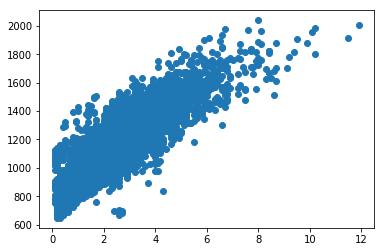

In [5]:
plt.scatter(df['CO(GT)'], df['PT08.S1(CO)'])

In [95]:
df_c = df.loc[:, ['CO(GT)', 'PT08.S1(CO)']].dropna()
np.corrcoef(df_c['CO(GT)'], df_c['PT08.S1(CO)'],)

array([[1.        , 0.87928834],
       [0.87928834, 1.        ]])

Создадим один признак времени

In [7]:
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'].str.replace('.', ':'))

Оставим для исследования содержание веществ и температуру для пресказания

In [8]:
df1 = df.loc[:, ['datetime', 'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'T']].dropna()
df1['year'] = df1['datetime'].dt.year

Некоторые значения отсутствуют, удалим их

In [9]:
df1.shape

(8991, 7)

In [10]:
(9357-8991)/9357

0.0391151009939083

Всего удалено около 4% наблюдений, что приемлемо

In [11]:
df1.set_index(df1['datetime'], inplace=True)
df1.sort_index(inplace=True)

Отобразим зависимость температуры от времени

Text(0, 0.5, 'T')

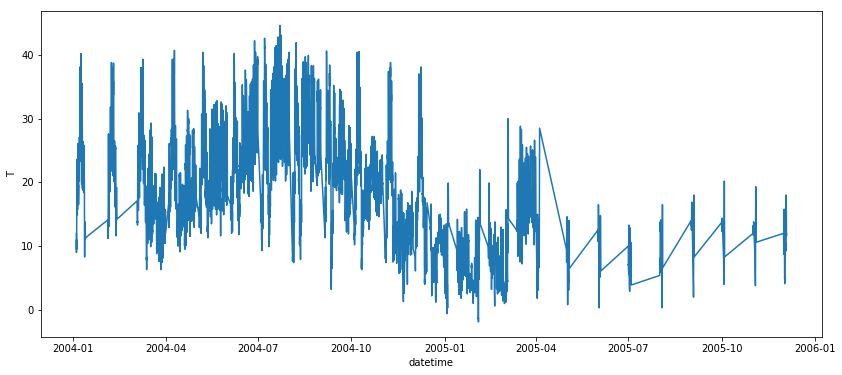

In [12]:
plt.figure(figsize=(14,6))
plt.plot(df1['T'])
plt.xlabel('datetime')
plt.ylabel('T')

Видно, что значения сильно колеблются. Посмотрим на средние значения.

Отобразим средние значения за разные периоды

Text(0.5, 1.0, 'Average Temperature over day')

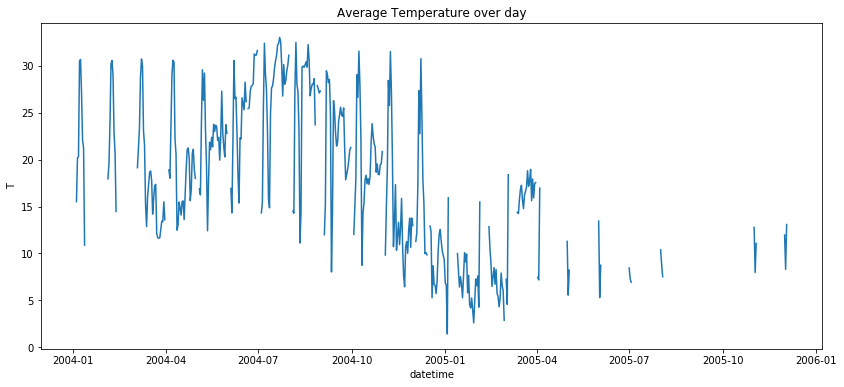

In [13]:
plt.figure(figsize=(14,6))
plt.plot(df1['T'].resample('d').mean())
plt.xlabel('datetime')
plt.ylabel('T')
plt.title('Average Temperature over day')

Text(0.5, 1.0, 'Average Temperature over week')

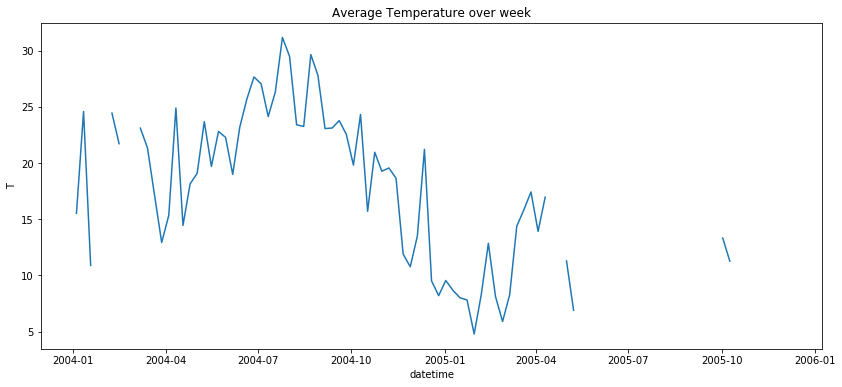

In [14]:
plt.figure(figsize=(14,6))
plt.plot(df1['T'].resample('w').mean())
plt.xlabel('datetime')
plt.ylabel('T')
plt.title('Average Temperature over week')

Text(0.5, 1.0, 'Average Temperature over month')

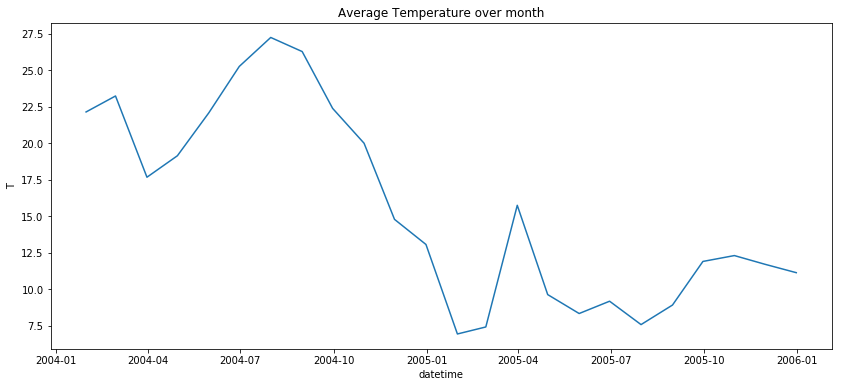

In [15]:
plt.figure(figsize=(14,6))
plt.plot(df1['T'].resample('m').mean())
plt.xlabel('datetime')
plt.ylabel('T')
plt.title('Average Temperature over month')

Температура снижается в 2005 году, отобразим значения за разные года

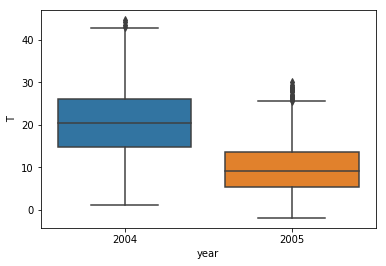

In [16]:
import seaborn as sns 

sns.boxplot(x="year", y="T", data=df1)

In [17]:
df_c = df.loc[:, ['CO(GT)', 'PT08.S1(CO)']].dropna()
np.corrcoef(df_c['CO(GT)'], df_c['PT08.S1(CO)'],)

array([[1.        , 0.87928834],
       [0.87928834, 1.        ]])

Написать LSTM не вышло, по презентации проекта не было понятно, что нужно разбираться в нейросетях